# **Imports**

In [1]:
import ast
import datetime as dt
from fastai.vision.all import *
import io

import matplotlib.image as image
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from numpy import array
from numpy import argmax

import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

import pandas as pd

from PIL import Image

from scipy.io import loadmat

import shutil

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tarfile

import time

import torch
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models import mnasnet1_3, MNASNet1_3_Weights
from torchvision.transforms import functional as F
%matplotlib inline

# **Use GPU**

In [2]:
''' Get available device, preferably GPU '''
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cuda:0


# **Download stanford-dogs-dataset**

In [3]:
# open file
images_exists = exists('images.tar')

if images_exists:
    os.remove('images.tar')

# open file
images_exists = exists('./stanford-dogs-dataset/Images')

if images_exists:
    shutil.rmtree('./stanford-dogs-dataset/Images')

!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"

images_file = tarfile.open('images.tar')

# extract files
images_file.extractall('./stanford-dogs-dataset')

# close file
images_file.close()

--2025-07-06 21:19:45--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  21.2MB/s    in 40s     

2025-07-06 21:20:25 (19.2 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [4]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

# open file
lists_file = tarfile.open('lists.tar')

# print file names
print(lists_file.getnames())

# extract files
lists_file.extractall('./stanford-dogs-dataset')

# close file
lists_file.close()

--2025-07-06 21:20:30--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘lists.tar’

lists.tar           100%[===================>] 470.00K  2.74MB/s    in 0.2s    

2025-07-06 21:20:30 (2.74 MB/s) - ‘lists.tar’ saved [481280/481280]

['file_list.mat', 'train_list.mat', 'test_list.mat']


In [5]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat"
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat"

--2025-07-06 21:20:30--  http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1247551328 (1.2G) [text/plain]
Saving to: ‘train_data.mat’

train_data.mat      100%[===================>]   1.16G  23.3MB/s    in 69s     

2025-07-06 21:21:40 (17.2 MB/s) - ‘train_data.mat’ saved [1247551328/1247551328]

--2025-07-06 21:21:40--  http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892614155 (851M) [text/plain]
Saving to: ‘test_data.mat’

test_data.mat       100%[===================>] 851.26M  59.8MB/s    in 17s     

2025-07-06 21:21:57 (50.0 MB/s) - ‘test_d

# **Static variables**

In [6]:
# static variables
data_set_path = Path("/content/stanford-dogs-dataset/")

In [7]:
list(data_set_path.ls())

[Path('/content/stanford-dogs-dataset/Images'),
 Path('/content/stanford-dogs-dataset/file_list.mat'),
 Path('/content/stanford-dogs-dataset/train_list.mat'),
 Path('/content/stanford-dogs-dataset/test_list.mat')]

# **Create Labels list**

In [8]:
test_filenames = [o[0][0] for o in loadmat(data_set_path/'test_list.mat')['file_list']]
train_filenames = [o[0][0] for o in loadmat(data_set_path/'train_list.mat')['file_list']]

In [9]:
len(train_filenames), len(test_filenames)

(12000, 8580)

In [10]:
train_labels = L(train_filenames).map(lambda o: o.split("/")[0])

In [11]:
def one_hot_encode(labels, label_encoder=None):
    values = np.array(labels)

    # Use provided encoder or create a new one
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(values)

    integer_encoded = label_encoder.transform(values)

    onehot_encoder = OneHotEncoder(sparse_output=False)
    col_vec_integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(col_vec_integer_encoded)

    onehot_encoded_list = [list(map(float, label)) for label in onehot_encoded]

    return integer_encoded, onehot_encoded_list, label_encoder

In [12]:
def reverse_encode(label_encoder, int_enc_label):
    return label_encoder.inverse_transform([int_enc_label])[0]

# **Create Train/Test data frames**

In [13]:
test_labels = L(test_filenames).map(lambda o: o.split("/")[0])

In [14]:
# First fit the encoder once on all labels (train + test)
all_labels = train_labels + test_labels
_, _, shared_encoder = one_hot_encode(all_labels)

# Now use the same encoder for both
int_enc_train_labels, train_labels_ohe, _ = one_hot_encode(train_labels, shared_encoder)
int_enc_test_labels, test_labels_ohe, _ = one_hot_encode(test_labels, shared_encoder)

In [15]:
# Create DataFrame
train_df = pd.DataFrame({"filenames": train_filenames, "labels": train_labels_ohe})

In [16]:
test_df = pd.DataFrame({"filenames":test_filenames, "labels": test_labels_ohe})

In [17]:
train_df.to_csv(data_set_path/"train.csv", index=False)
test_df.to_csv(data_set_path/"test.csv", index=False)

In [18]:
train_df.shape, test_df.shape

((12000, 2), (8580, 2))

# **Define StanfordDogsDataset**

In [19]:
class StanfordDogsDataset(Dataset):
    def __init__(self, labels, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(labels)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels_str = self.labels.iloc[idx, 1]
        labels = np.array(ast.literal_eval(labels_str)).astype('float')
        label = np.argmax(labels)

        if self.transform:
            image = self.transform(image)

        return [image, label]

In [20]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow((inp * 255).astype(np.uint8))

# **Create Train/Test data sets and data loaders**

In [21]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

train_trans = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

str_data_path = str(Path(data_set_path))

# creating train data set and data loader
train_labels_path = str_data_path + "/train.csv"
print(train_labels_path)
root_path = str_data_path + "/Images/"
print(root_path)

train_dogs_dataset = StanfordDogsDataset(labels = train_labels_path,
                                         root_dir = root_path, transform=train_trans)

print(len(train_dogs_dataset))

whole_train_dl = DataLoader(train_dogs_dataset,
                            batch_size=64, shuffle=True, num_workers=2)

print(len(whole_train_dl))

# creating test data set and data loader
test_labels_path = str_data_path + "/test.csv"
print(test_labels_path)
root_path = str_data_path + "/Images/"
print(root_path)

test_dogs_dataset = StanfordDogsDataset(labels = test_labels_path,
                                        root_dir = root_path, transform=test_trans)

print(len(test_dogs_dataset))

test_dl = DataLoader(test_dogs_dataset,
                    batch_size=64, shuffle=True, num_workers=2)
print(len(test_dl))

/content/stanford-dogs-dataset/train.csv
/content/stanford-dogs-dataset/Images/
12000
188
/content/stanford-dogs-dataset/test.csv
/content/stanford-dogs-dataset/Images/
8580
135


# **Visualize a batch of train's data loader**

64 64


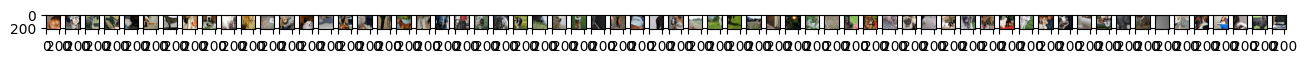

In [22]:
img, label = next(iter(whole_train_dl))
print(len(img), len(label))
fig = plt.figure(1, figsize=(16, 64))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 64), axes_pad=0.05)

for i in range(len(img)):
    ax = grid[i]
    imshow(ax, img[i])

In [23]:
np.random.seed(0)

# **Download pretrained models**

In [24]:
! mkdir -p pretrained-pytorch-models/

In [25]:
!ls pretrained-pytorch-models/

In [26]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [27]:
!cp -r pretrained-pytorch-models/ ~/.torch/models/

In [28]:
!ls ~/.torch/models

pretrained-pytorch-models


In [29]:
!ls stanford-dogs-dataset

file_list.mat  Images  test.csv  test_list.mat	train.csv  train_list.mat


In [30]:
# !wget -c "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth"
!wget -c "https://download.pytorch.org/models/mnasnet1_3-a4c69d6f.pth"

--2025-07-06 21:22:07--  https://download.pytorch.org/models/mnasnet1_3-a4c69d6f.pth
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.96, 99.86.38.106, 99.86.38.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25423373 (24M) [application/x-www-form-urlencoded]
Saving to: ‘mnasnet1_3-a4c69d6f.pth’

mnasnet1_3-a4c69d6f 100%[===================>]  24.25M  30.6MB/s    in 0.8s    

2025-07-06 21:22:08 (30.6 MB/s) - ‘mnasnet1_3-a4c69d6f.pth’ saved [25423373/25423373]



In [31]:
!mv mnasnet1_3-a4c69d6f.pth pretrained-pytorch-models/mnasnet1_3-a4c69d6f.pth

# **Define the model**

In [32]:
# Path to the uploaded model file on Kaggle
model_path = 'pretrained-pytorch-models/mnasnet1_3-a4c69d6f.pth'

# Load the pretrained model
mnasneta = models.mnasnet1_3()
mnasneta.load_state_dict(torch.load(model_path))

# Freeze all model parameters
for param in mnasneta.parameters():
    param.requires_grad = False

# New final layer with 120 classes (modify if needed)
num_ftrs = mnasneta.classifier[-1].in_features
mnasneta.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(num_ftrs, 120)
)

# Move the model to GPU if available
mnasneta = mnasneta.to(device)

# **Training loop**

In [33]:
# Training function
def train_model(train_loader, test_loader, model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()
    lrs = []
    train_accs = []
    train_loss = []
    test_accs = []
    test_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Save the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_loss.append(epoch_loss)
        train_accs.append(epoch_acc.cpu().numpy())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

        test_loss.append(epoch_loss)
        test_accs.append(epoch_acc.cpu().numpy())
        print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, lrs, train_loss, train_accs, test_loss, test_accs

# **Define Loss function, optimizer and lr_scheduler**

In [34]:
criterion = torch.nn.CrossEntropyLoss()

# Use named_parameters to get both the name and the parameter
bias_params = [p for name, p in mnasneta.classifier.named_parameters() if 'bias' in name]
others = [p for name, p in mnasneta.classifier.named_parameters() if 'bias' not in name]

# Create the optimizer with separate parameter groups
optimizer = torch.optim.Adam([
    {'params': others, 'weight_decay':1e-4},
    {'params': bias_params, 'weight_decay': 0}
], lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# **Training the model**

In [35]:
start_time = time.time()
model, lrs, train_loss, train_accs, test_loss, test_accs = train_model(whole_train_dl, test_dl, mnasneta, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch 0/9
----------
Train Loss: 3.1645 Acc: 0.3969
Test Loss: 1.5518 Acc: 0.7949
Epoch 1/9
----------
Train Loss: 1.8766 Acc: 0.6021
Test Loss: 0.9393 Acc: 0.8325
Epoch 2/9
----------
Train Loss: 1.5956 Acc: 0.6288
Test Loss: 0.7392 Acc: 0.8486
Epoch 3/9
----------
Train Loss: 1.4397 Acc: 0.6567
Test Loss: 0.6472 Acc: 0.8520
Epoch 4/9
----------
Train Loss: 1.3901 Acc: 0.6585
Test Loss: 0.5992 Acc: 0.8502
Epoch 5/9
----------
Train Loss: 1.3560 Acc: 0.6612
Test Loss: 0.5632 Acc: 0.8550
Epoch 6/9
----------
Train Loss: 1.3052 Acc: 0.6729
Test Loss: 0.5409 Acc: 0.8572
Epoch 7/9
----------
Train Loss: 1.2732 Acc: 0.6812
Test Loss: 0.5295 Acc: 0.8577
Epoch 8/9
----------
Train Loss: 1.2450 Acc: 0.6863
Test Loss: 0.5193 Acc: 0.8599
Epoch 9/9
----------
Train Loss: 1.2162 Acc: 0.6913
Test Loss: 0.5077 Acc: 0.8627
Training complete in 15m 5s
Training time:  15.076345 minutes


In [36]:
torch.save(model.state_dict(), "model.pt")

# **Visualizations**

In [37]:
def plot_2_graphs(model_name, y_title, x_title, train_y, test_y):
    # plotting the points
    title = model_name + " - " + "Train" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(train_y, label = title)
    title = model_name + " - " + "Test" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(test_y, label = title)

    plt.legend()

    # function to show the plot
    plt.show()

def plot_graph(model_name, y_title, x_title, y):
    # plotting the points
    title = model_name + " - " + "Train" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(y, label = title)

    plt.legend()

    # function to show the plot
    plt.show()

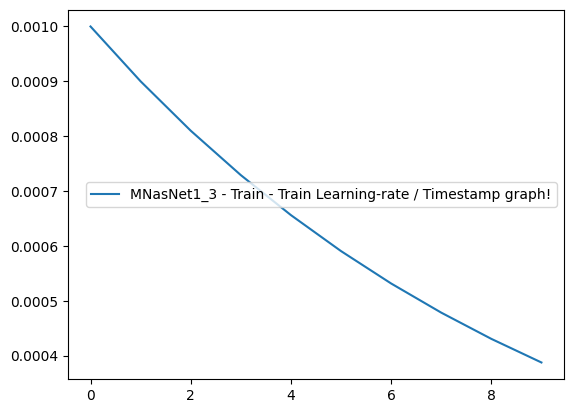

In [38]:
plot_graph("MNasNet1_3", "Train Learning-rate", "Timestamp", lrs)

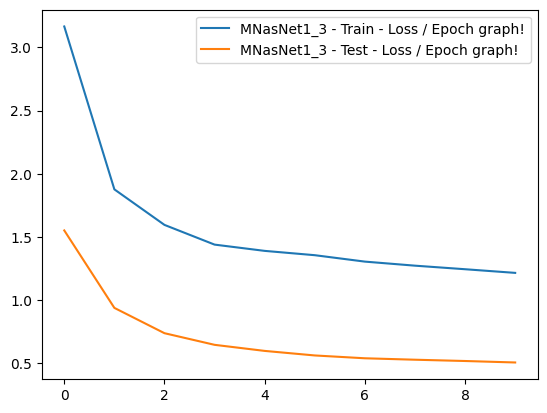

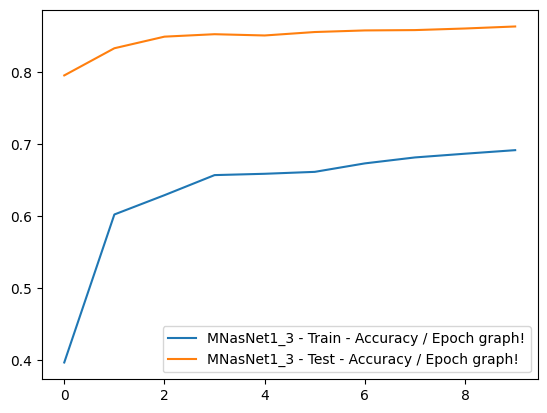

In [39]:
plot_2_graphs("MNasNet1_3", "Loss", "Epoch", train_loss, test_loss)
plot_2_graphs("MNasNet1_3", "Accuracy", "Epoch", train_accs, test_accs)

# **Test Loop**

In [40]:
def test_model(dataloader, model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)

    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print()

    time_elapsed = time.time() - since
    print(f'Test complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return epoch_loss, epoch_acc

# **Testing the model**

In [41]:
start_time = time.time()
test_loss, test_accs = test_model(test_dl, model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)
print('Test time: {:10f} minutes'.format((time.time()-start_time)/60))

Loss: 0.5077 Acc: 0.8627

Test complete in 0m 41s
Test time:   0.690227 minutes


# **visualize a single test example**

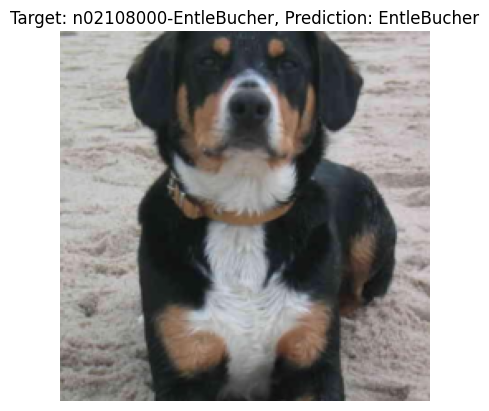

In [42]:
# Function to visualize a single test example
def visualize_test_example(dataloader, model):
    model.eval()

    with torch.no_grad():
        # Get a single batch from the dataloader
        inputs, labels = next(iter(dataloader))
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Get the first image and its label and prediction
        input_img = inputs[0].cpu()
        label = labels[0].cpu().item()
        str_label = reverse_encode(shared_encoder, label)
        pred = preds[0].cpu().item()
        str_pred = reverse_encode(shared_encoder, pred)
        clean_pred = str_pred.split('-', 1)[1] if '-' in str_pred else str_pred

        # Denormalize the image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        input_img = input_img.permute(1, 2, 0).numpy() * std + mean
        input_img = np.clip(input_img, 0, 1)

        # Plot the image with target and prediction
        plt.imshow(input_img)
        plt.title(f'Target: {str_label}, Prediction: {clean_pred}')
        plt.axis('off')
        plt.show()

visualize_test_example(test_dl, model)